<a href="https://colab.research.google.com/github/absallh/GP/blob/master/mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import shutil
import random
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [2]:
#set up kaggle
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d paultimothymooney/blood-cells

 93% 101M/108M [00:02<00:00, 32.1MB/s] 
100% 108M/108M [00:02<00:00, 38.7MB/s]


In [4]:
!unzip blood-cells; rm -v blood-cells.zip

Archive:  blood-cells.zip
replace dataset-master/dataset-master/Annotations/BloodImage_00000.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
removed 'blood-cells.zip'


In [5]:
train_path = '/content/dataset2-master/dataset2-master/images/TRAIN'
test_path = '/content/dataset2-master/dataset2-master/images/TEST_SIMPLE'
valid_path = '/content/dataset2-master/dataset2-master/images/TEST'

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10
)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False
)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10
)

Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [8]:
imgs, labels = next(train_batches)

In [9]:
mobile = keras.applications.mobilenet.MobileNet()

In [10]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [11]:
type(mobile)

keras.engine.functional.Functional

In [12]:
model = keras.Sequential()
for layer in mobile.layers[:-1]:
  model.add(layer)

In [13]:
for layer in model.layers:
  layer.trainable = False

In [14]:
model.add(keras.layers.Dense(4, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)      0

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_batches, validation_data=valid_batches, steps_per_epoch=len(train_batches), validation_steps=len(valid_batches), epochs=100, verbose=2)

Epoch 1/100
996/996 - 33s - loss: 1.0276 - accuracy: 0.6113 - val_loss: 1.1548 - val_accuracy: 0.6035 - 33s/epoch - 33ms/step
Epoch 2/100
996/996 - 28s - loss: 0.6760 - accuracy: 0.7384 - val_loss: 1.1442 - val_accuracy: 0.6253 - 28s/epoch - 28ms/step
Epoch 3/100
996/996 - 27s - loss: 0.5575 - accuracy: 0.7824 - val_loss: 1.1437 - val_accuracy: 0.6072 - 27s/epoch - 27ms/step
Epoch 4/100
996/996 - 27s - loss: 0.5295 - accuracy: 0.7977 - val_loss: 1.3760 - val_accuracy: 0.5553 - 27s/epoch - 27ms/step
Epoch 5/100
996/996 - 27s - loss: 0.4939 - accuracy: 0.8121 - val_loss: 1.3362 - val_accuracy: 0.5951 - 27s/epoch - 27ms/step
Epoch 6/100
996/996 - 27s - loss: 0.4943 - accuracy: 0.8111 - val_loss: 1.3949 - val_accuracy: 0.5947 - 27s/epoch - 27ms/step
Epoch 7/100
996/996 - 27s - loss: 0.4575 - accuracy: 0.8260 - val_loss: 1.3248 - val_accuracy: 0.5858 - 27s/epoch - 27ms/step
Epoch 8/100
996/996 - 27s - loss: 0.4538 - accuracy: 0.8305 - val_loss: 1.2280 - val_accuracy: 0.6437 - 27s/epoch - 27

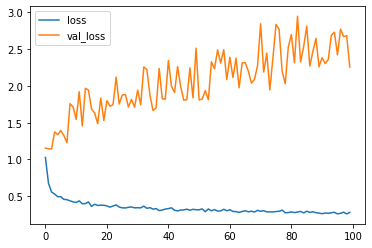

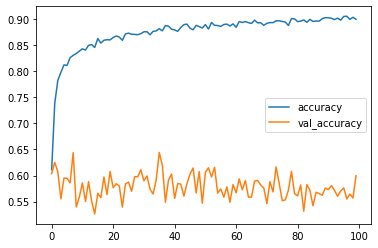

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=0)

In [30]:
from numpy import argmax
predictions = argmax(predictions, axis=1)

In [31]:
predictions

array([3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3])

In [32]:
confusion_matrix(test_labels, predictions)

array([[ 3,  2,  0,  8],
       [ 0,  2,  0,  4],
       [ 1,  0,  0,  3],
       [ 0,  3,  1, 44]])

In [33]:
import seaborn as sns
def print_conf_mat(pred, y_values):
  cf_matrix = confusion_matrix(y_values,pred)
  df_cf_matrix = pd.DataFrame(cf_matrix, index = [i for i in range(4)],
                    columns = [i for i in range(4)])

  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df_cf_matrix, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='d')
  ax.set_xticklabels(('Cloudy','Desert','Green area','Water'))
  ax.set_yticklabels(('Cloudy','Desert','Green area','Water'))


  plt.title('confusion matrix')

  plt.show()

  print(classification_report(y_values,pred)) # 0 = Cloudy, 1 = desert, 2 = green_area, 3 = water

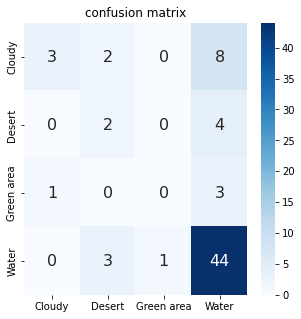

              precision    recall  f1-score   support

           0       0.75      0.23      0.35        13
           1       0.29      0.33      0.31         6
           2       0.00      0.00      0.00         4
           3       0.75      0.92      0.82        48

    accuracy                           0.69        71
   macro avg       0.45      0.37      0.37        71
weighted avg       0.67      0.69      0.65        71



In [34]:
print_conf_mat(predictions, test_labels)